# Measuring US Industry Level Productivity for 1947-2023
## [Juan Ignacio Vizcaino](https://www.jivizcaino.com/) and [Selim Elbadri](https://www.selimelbadri.com/) 

We combine data from US KLEMS, March 2017 Release, with BEA-BLS Integrated Industry-Level Production Account for 1947–2016, and BEA-BLS Integrated Industry-Level Production Account for 1997-2023 to produce industry-level measures of Gross Output (**GO**), Value Added (**VA**), Capital (**CAP**), Labor (**LAB**), and Intermediate Inputs (**II**), in Nominal  terms. We also provide Quantity Indices for **GO**, **VA**, **CAP**, **LAB**, **II** and total hours employed (**HRS**), and utilize these indices to compute measures of Total Labor Productivity (**LP**) and Total Factor Productivity (**TFP**) for the corresponding time period, following the methodology in US KLEMS, April 2013 Release.
See our [Gihub repo](https://github.com/selbadri/Measuring-US-Industry-Level-Productivity-1947-to-2023) for details on data processing. 



# Introduction

We construct the final dataset in two stages.
Step 1 merges the raw datasets and standardizes all variables. This step, implemented in clean.ipynb, produces [clean_data.xlsx](../Output/clean_data.xlsx) — a unified dataset containing the core variables for 44 industries (1947–2023) and 63 industries (1963–2023). It includes nominal series for **GO**, **CAP**, **LAB**, **II**, and **VA**, as well as nominal compensation values and quantity indices for each input type.

Step 2, implemented by [analysis.ipynb](./analysis.ipynb), uses clean_data.xlsx to aggregate the growth rates of the various **CAP**, **LAB**, and **II** types, weighting them by their nominal compensation shares to generate the corresponding quantity indices. Combined with the **GO** quantity index, we use these to produce the **VA** quantity index and the productivity measures. The final output is [EV_production_accounts_1947to2023.xlsx](../Output/EV_production_accounts_1947to2023.xlsx).

In addition to the construction of the dataset, we offer a code ([validation.ipynb](./validation.ipynb)) that verifies our dataset against well-established and comparable datasets. This is implemented in validation.ipynb. Specifically, we compare industry- and broad-sector level **GO** and **VA** shares as well as US economy-wide quantity and productivity indices (**GO**, **CAP**, **LAB**, **II**, **VA**, **TFPVA** and **LPVA**).

Running the notebook [run_all.ipynb](./run_all.ipynb) automatically executes [clean.ipynb](./clean.ipynb), followed by [analysis.ipynb](./analysis.ipynb) and then validation.ipynb, so there is no need to open the three notebooks. 

1. [Preliminaries](#1-preliminaries)  
   - [1.1 Set-up working directory](#11-set-up-working-directory)  
   - [1.2 Import required libraries](#12-import-required-libraries)  
   - [1.3 Define widely used functions](#13-define-widely-used-functions)  
   - [1.4 Define widely used lists](#14-define-widely-used-lists)  
   - [1.5 Set the seed](#15-set-the-seed)  

2. [Import relevant datasets](#2-import-relevant-datasets)  
   - [2.1 Import Elbadri and Vizcaino (2025)](#21-import-elbadri-and-vizcaino-2025)  
   - [2.2 Import Penn World Tables](#22-import-penn-world-tables)  
   - [2.3 Import US KLEMS, April 2013 Release](#23-import-us-klems-april-2013-release)  
   - [2.4 Import US KLEMS, March 2017 Release](#24-import-us-klems-march-2017-release)  
   - [2.5 Aggregate federal and state local government industries in US KLEMS (March 2017 Release)](#25-aggregate-federal-and-state-local-government-industries-in-us-klems-march-2017-release)  

3. [Compare Industry-Level GO and VA Shares](#3-compare-industry-level-go-and-va-shares)  
   - [3.1 Compute annual industry-level GO and VA shares of total](#31-compute-annual-industry-level-go-and-va-shares-of-total)  
   - [3.2 Randomly choose an industry for validation checks](#32-randomly-choose-an-industry-for-validation-checks)  
   - [3.3 Plot annual industry-level GO shares](#33-plot-annual-industry-level-go-shares)  
   - [3.4 Plot annual industry-level VA shares](#34-plot-annual-industry-level-va-shares)  

4. [Compare Structural Change Trends](#4-compare-structural-change-trends)  
   - [4.1 Group industries into 3 broad sectors](#41-group-industries-into-3-broad-sectors)  
   - [4.2 Collapse sum VA and GO by broad sector](#42-collapse-sum-va-and-go-by-broad-sector)  
   - [4.3 Plot agriculture, industry and services VA shares](#43-plot-agriculture-industry-and-services-va-shares)  
   - [4.4 Plot agriculture, industry and services GO shares](#44-plot-agriculture-industry-and-services-go-shares)  

5. [Compare US Productivity Trends](#5-compare-us-productivity-trends)  
   - [5.1 Reshape US KLEMS, April 2013 Release](#51-reshape-us-klems-april-2013-release)  
   - [5.2 Rebase quantity variables](#52-rebase-quantity-variables)  
   - [5.3 Compute economy-wide QI indices using both datasets](#53-compute-economy-wide-qi-indices-using-both-datasets)  
   - [5.4 Plot results and compare with World KLEMS, April 2013 Release](#54-plot-results-and-compare-with-world-klems-april-2013-release)  
   - [5.5 Rebase PWT TFP measure to 1954](#55-rebase-pwt-tfp-measure-to-1954)  
   - [5.6 Plot results and compare with Penn World Tables v11.0](#56-plot-results-and-compare-with-penn-world-tables-v11-0)

<a id="1-preliminaries"></a>
# 1 Preliminaries

<a id="11-set-up-working-directory"></a>
#### 1.1 Set-up working directory

In [1]:
EV_data_path    = rf"..\\Output"
input_data_path = rf"..\\Input"

<a id="12-import-required-libraries"></a>
#### 1.2 Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

<a id="13-define-widely-used-functions"></a>
#### 1.3 Define widely used functions

In [3]:
def log_difference(df, id_col='industry_id', year_col='year'):
    """
    Compute log-difference growth rates for quantity index variables by industry and year.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the quantity indices and year column.
    id_col : str
        Column to group by (e.g., 'industry_id').
    year_col : str
        Year column (e.g., 'year').

    Returns
    -------
    pd.DataFrame
        DataFrame with new columns for log-difference growth rates (e.g., 'GO_QI_g', 'VA_QI_g').
    """
    qi_vars              = ['GO_QI','LAB_QI','CAP_QI','II_QI','VA_QI','LPVA','TFPVA']
    df                   = df.copy()
    df                   = df.sort_values([id_col, year_col])
    for v in qi_vars:
        if v in df.columns:
            df[v + '_g'] = df.groupby(id_col)[v].transform(
                lambda s: np.where(s > 0, np.log(s) - np.log(s.shift(1)), np.nan)
            )
    return df

In [4]:
def tornqvist_weights(df, id_col='industry_id', year_col='year', va_col='VA'):
    """
    Compute value-added shares and Tornqvist weights for each industry and year.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing value added and year column.
    id_col : str
        Column to group by (e.g., 'industry_id').
    year_col : str
        Year column (e.g., 'year').
    va_col : str
        Value added column (e.g., 'VA').

    Returns
    -------
    pd.DataFrame
        DataFrame with new columns for value-added shares and Tornqvist weights.
    """
    df                       = df.copy()
    if va_col in df.columns:
        df['total_VA']       = df.groupby(year_col)[va_col].transform('sum')
        df['VA_share']       = df[va_col] / df['total_VA']
        df['VA_share_lag']   = df.groupby(id_col)['VA_share'].shift(1)
        df['VA_tornq_share'] = 0.5 * (df['VA_share'] + df['VA_share_lag'])
    return df

<a id="14-define-widely-used-lists"></a>
#### 1.4 Define widely used lists

The list *aggregate_groups* is useful to aggregate industries at the same level as the BEA-BLS Industry Production Account Experimental for the period of 1947-1963. 

In [5]:
aggregate_groups = {
    2936: list(range(29, 37)),
    3740: list(range(37, 41)),
    4144: list(range(41, 45)),
    4749: list(range(47, 50)),
    5152: list(range(51, 53)),
    5456: list(range(54, 57)),
    5758: list(range(57, 59))
}

<a id="15-set-the-seed"></a>
#### 1.5 Set the seed

The seed determines which industries are selected for validation checks. 

In [6]:
np.random.seed(15)

<a id="2-import-relevant-datasets"></a>
# 2. Import relevant datasets

<a id="21-import-elbadri-and-vizcaino-2025"></a>
#### 2.1 Import Elbadri & Vizcaino (2025)

In [7]:
file          = os.path.join(EV_data_path, "EV_production_accounts_1947to2023.xlsx")
EV_full       = pd.read_excel(file, sheet_name="Data_44Ind_1947to2023")

In [8]:
prod_accounts = ['year', 'industry_id', 'GO', 'CAP', 'LAB', 'II', 'VA']
file          = os.path.join(EV_data_path, "EV_production_accounts_1947to2023.xlsx")
EV_nom        = pd.read_excel(file, sheet_name="Data_44Ind_1947to2023",usecols=prod_accounts)

<a id="22-import-penn-world-tables"></a>
#### 2.2 Import Penn World Tables

In [9]:
pwt_file    = os.path.join(input_data_path, "pwt110.xlsx")
pwt110_data = pd.read_excel(pwt_file, sheet_name="Data")

<a id="23-import-us-klems-april-2013-release"></a>
#### 2.3 Import US KLEMS, April 2013 Release

In [10]:
klems_2013_file = os.path.join(input_data_path, 'usa_wk_apr_2013.xlsx')
df_klems_2013   = pd.read_excel(klems_2013_file, sheet_name='DATA')

<a id="24-import-us-klems-march-2017-release"></a>
#### 2.4 Import US KLEMS, March 2017 Release

In [11]:
klems_vars                    = ['year', 'industry', 'gross output', 'capital', 'labor', 'intermediate']
df_klems_2017                 = pd.read_excel(os.path.join(input_data_path, 'usa_wk_mar_2017.xlsx'), sheet_name='KLEMdata', skiprows=1, usecols=klems_vars)
df_klems_2017.rename(columns  ={'industry': 'industry_id', 'gross output': 'GO','capital': 'CAP','labor': 'LAB','intermediate': 'II'}, inplace=True)
df_klems_2017["VA"]           = df_klems_2017["GO"] - df_klems_2017["II"]

<a id="25-aggregate-federal-and-state-local-government-industries-in-us-klems-march-2017-release"></a>
#### 2.5 Aggregate federal & state/local government industries in US KLEMS (March 2017 Release)

Industries 62/63 are Federal General Government and Federal Government Enterprises while Industries 64/65 are State & Local Government Enterprises and State & Local General Government, respectively. Merge them together for the same industry classification system as Elbadri & Vizcaino (2025). 

In [12]:
federal_inds               = [62, 63]
state_local_inds           = [64, 65]
federal                    = df_klems_2017[df_klems_2017['industry_id'].isin(federal_inds)].groupby('year', as_index=False)[['GO', 'CAP', 'LAB', 'II', 'VA']].sum()
state_local                = df_klems_2017[df_klems_2017['industry_id'].isin(state_local_inds)].groupby('year', as_index=False)[['GO', 'CAP', 'LAB', 'II', 'VA']].sum()
federal['industry_id']     = 62           
state_local['industry_id'] = 63           
df_klems_2017              = df_klems_2017[~df_klems_2017['industry_id'].isin(federal_inds + state_local_inds)]
df_klems_2017              = pd.concat([df_klems_2017, federal, state_local], ignore_index=True)

<a id="3-compare-industry-level-go-and-va-shares"></a>
# 3. Compare Industry-Level GO and VA Shares

<a id="31-compute-annual-industry-level-go-and-va-shares-of-total"></a>
#### 3.1 Compute annual industry-level GO and VA shares of total

In [13]:
for df in (EV_nom, df_klems_2017):
    df['total_GO'] = df.groupby('year')['GO'].transform('sum')
    df['GO_share'] = df['GO'] / df['total_GO']
for df in (EV_nom, df_klems_2017):
    df['total_VA'] = df.groupby('year')['VA'].transform('sum')
    df['VA_share'] = df['VA'] / df['total_VA']

<a id="32-randomly-choose-an-industry-for-validation-checks"></a>
#### 3.2 Randomly choose an industry for validation checks

To change industries, change the seed in 1.4. When randomly choosing the industry, exclude from the list of potential industries the list of industries *aggregate_groups* as these have been aggregated in Elbadri & Vizcaino (2025). 

In [14]:
excluded         = [ind for inds in aggregate_groups.values() for ind in inds]
valid_industries = [i for i in range(1, 65) if i not in excluded]
ind_no           = int(np.random.randint(1, 64))

<a id="33-plot-annual-industry-level-go-shares"></a>
#### 3.3 Plot annual industry-level GO shares generated from each dataset

We plot the industry-level GO share generated from both datasets -- the dataset we produce and the US KLEMS, March 2017 release.

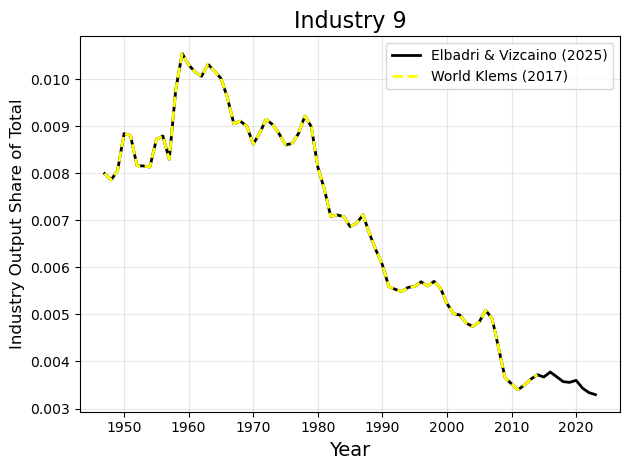

In [15]:
EV_2025    = EV_nom.loc[EV_nom['industry_id'] == ind_no, ['year', 'GO_share']].dropna().sort_values('year')
KLEMS_2017 = df_klems_2017.loc[df_klems_2017['industry_id'] == ind_no, ['year', 'GO_share']].dropna().sort_values('year')

plt.plot(EV_2025['year'], EV_2025['GO_share'], 
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_2017['year'], KLEMS_2017['GO_share'], 
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)') 

plt.xlabel('Year', fontsize=14)
plt.ylabel('Industry Output Share of Total', fontsize=12)
plt.title(f'Industry {ind_no}', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

<a id="34-plot-annual-industry-level-va-shares"></a>
#### 3.4 Plot annual industry-level VA shares generated from each dataset

We plot the industry-level VA share generated from both datasets -- the dataset we produce and the US KLEMS, March 2017 release.

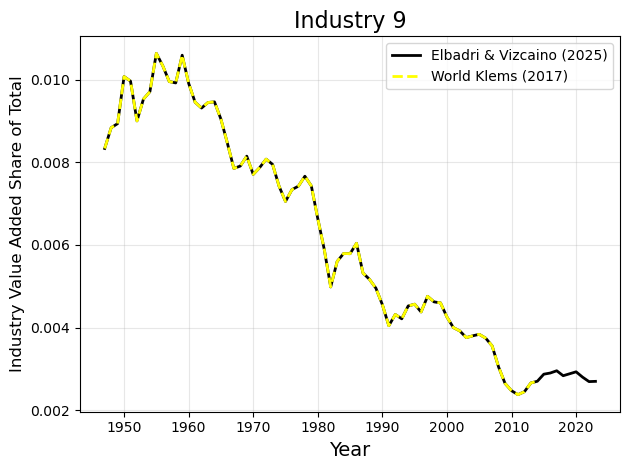

In [16]:
EV_2025    = EV_nom.loc[EV_nom['industry_id'] == ind_no, ['year', 'VA_share']].dropna().sort_values('year')
KLEMS_2017 = df_klems_2017.loc[df_klems_2017['industry_id'] == ind_no, ['year', 'VA_share']].dropna().sort_values('year')
 
plt.plot(EV_2025['year'], EV_2025['VA_share'], 
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_2017['year'], KLEMS_2017['VA_share'], 
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)') 
    
plt.xlabel('Year', fontsize=14)
plt.ylabel('Industry Value Added Share of Total', fontsize=12)
plt.title(f'Industry {ind_no}', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

<a id="4-compare-structural-change-trends"></a>
# 4. Compare Structural Change Trends

<a id="41-group-industries-into-3-broad-sectors"></a>
#### 4.1 Group industries into 3 broad sectors

We group all industries into the three broad categories consistent with the structural change literature: agriculture, industry and services. 

In [17]:
for df in [df_klems_2017, EV_nom]:
    df["sector"] = np.select(
        [
            df["industry_id"].between(1, 2),
            df["industry_id"].between(3, 26),
            (df["industry_id"].between(27, 63)) | (df["industry_id"] >= 2900)
        ],
        ["Agriculture", "Industry", "Services"],
        default=None
    )

<a id="42-collapse-sum-va-and-go-by-broad-sector"></a>
#### 4.2 Collapse sum VA and GO by broad sector

In [18]:
# Ensure both dataframes have a 'sector' column before aggregating
for df in [df_klems_2017, EV_nom]:
    if 'sector' not in df.columns:
        df["sector"] = np.select(
            [
                df["industry_id"].between(1, 2),
                df["industry_id"].between(3, 26),
                (df["industry_id"].between(27, 63)) | (df["industry_id"] >= 2900)
            ],
            ["Agriculture", "Industry", "Services"],
            default=None
        )

results = []
for df in [df_klems_2017, EV_nom]:
    # group by year and sector and sum VA and GO
    broad = df.groupby(["year", "sector"], as_index=False)[["VA", "GO"]].sum()
    broad["VA_share"] = broad["VA"] / broad.groupby("year")["VA"].transform("sum")
    broad["GO_share"] = broad["GO"] / broad.groupby("year")["GO"].transform("sum")
    results.append(broad)

KLEMS_2017_broadsect, EV_2025_broadsect = results


<a id="43-plot-agriculture-industry-and-services-va-shares"></a>
#### 4.3 Plot agriculture, industry and services VA shares

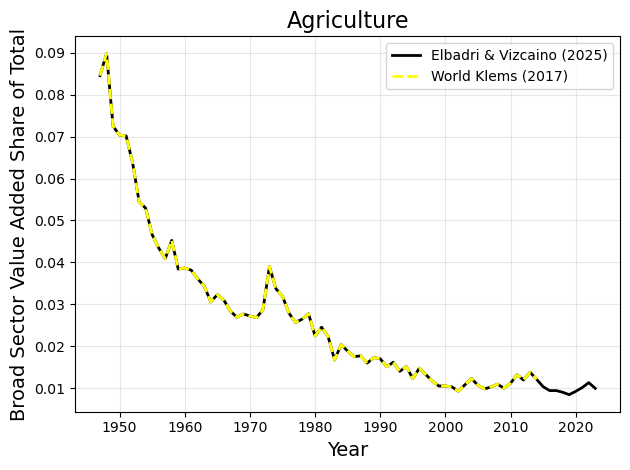

In [19]:
EV_agri    = EV_2025_broadsect.loc[EV_2025_broadsect['sector']       == "Agriculture", ['year', 'VA_share']]
KLEMS_agri = KLEMS_2017_broadsect.loc[KLEMS_2017_broadsect['sector'] == "Agriculture", ['year', 'VA_share']]

plt.plot(EV_agri['year'], EV_agri['VA_share'],
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_agri['year'], KLEMS_agri['VA_share'],
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Broad Sector Value Added Share of Total', fontsize=14)
plt.title('Agriculture', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


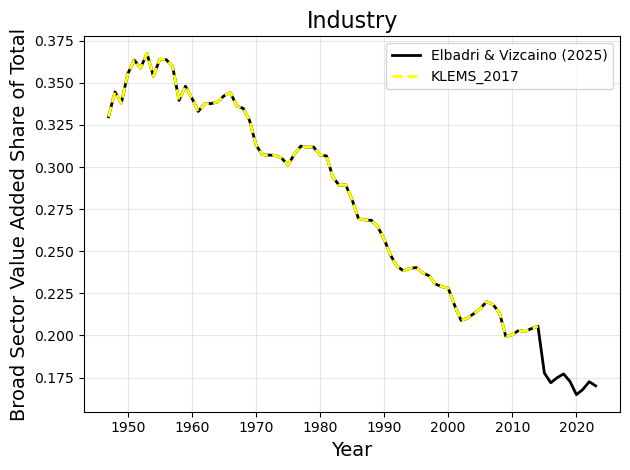

In [20]:
EV_ind    = EV_2025_broadsect.loc[EV_2025_broadsect['sector']       == "Industry", ['year', 'VA_share']]
KLEMS_ind = KLEMS_2017_broadsect.loc[KLEMS_2017_broadsect['sector'] == "Industry", ['year', 'VA_share']]

plt.plot(EV_ind['year'], EV_ind['VA_share'],
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_ind['year'], KLEMS_ind['VA_share'],
    color='yellow', linestyle='--', linewidth=2, label='KLEMS_2017')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Broad Sector Value Added Share of Total', fontsize=14)
plt.title('Industry', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


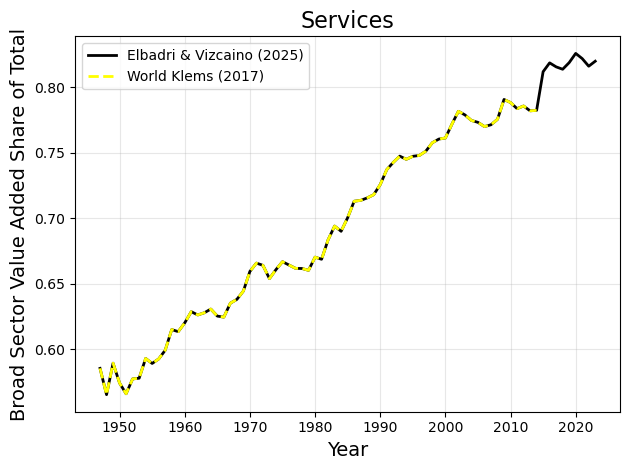

In [21]:
EV_serv    = EV_2025_broadsect.loc[EV_2025_broadsect['sector']       == "Services", ['year', 'VA_share']]
KLEMS_serv = KLEMS_2017_broadsect.loc[KLEMS_2017_broadsect['sector'] == "Services", ['year', 'VA_share']]

plt.plot(EV_serv['year'], EV_serv['VA_share'],
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_serv['year'], KLEMS_serv['VA_share'],
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Broad Sector Value Added Share of Total', fontsize=14)
plt.title('Services', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


<a id="44-plot-agriculture-industry-and-services-go-shares"></a>
#### 4.4 Plot agriculture, industry and services GO shares

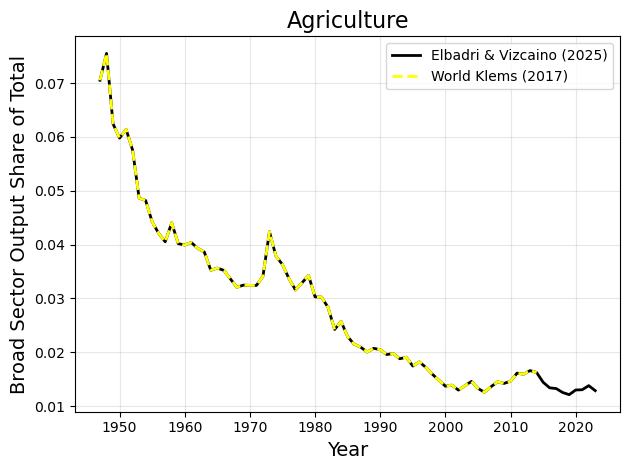

In [22]:
EV_agri    = EV_2025_broadsect.loc[EV_2025_broadsect['sector']       == "Agriculture", ['year', 'GO_share']]
KLEMS_agri = KLEMS_2017_broadsect.loc[KLEMS_2017_broadsect['sector'] == "Agriculture", ['year', 'GO_share']]

plt.plot(EV_agri['year'], EV_agri['GO_share'],
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_agri['year'], KLEMS_agri['GO_share'],
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Broad Sector Output Share of Total', fontsize=14)
plt.title('Agriculture', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


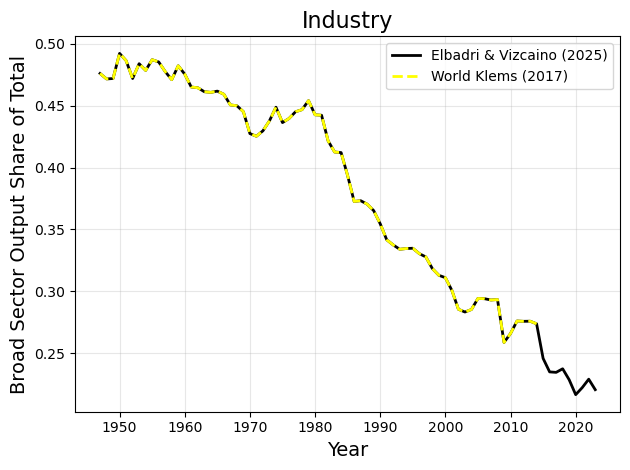

In [23]:
EV_ind    = EV_2025_broadsect.loc[EV_2025_broadsect['sector']       == "Industry", ['year', 'GO_share']]
KLEMS_ind = KLEMS_2017_broadsect.loc[KLEMS_2017_broadsect['sector'] == "Industry", ['year', 'GO_share']]

plt.plot(EV_ind['year'], EV_ind['GO_share'],
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_ind['year'], KLEMS_ind['GO_share'],
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Broad Sector Output Share of Total', fontsize=14)
plt.title('Industry', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


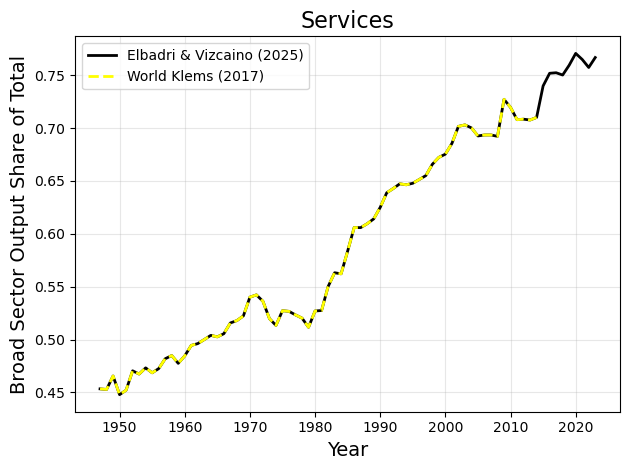

In [24]:
EV_serv    = EV_2025_broadsect.loc[EV_2025_broadsect['sector']       == "Services", ['year', 'GO_share']]
KLEMS_serv = KLEMS_2017_broadsect.loc[KLEMS_2017_broadsect['sector'] == "Services", ['year', 'GO_share']]

plt.plot(EV_serv['year'], EV_serv['GO_share'],
    color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(KLEMS_serv['year'], KLEMS_serv['GO_share'],
    color='yellow', linestyle='--', linewidth=2, label='World Klems (2017)')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Broad Sector Output Share of Total', fontsize=14)
plt.title('Services', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


<a id="5-compare-us-productivity-trends"></a>
# 5. Compare US Productivity Trends

<a id="51-reshape-us-klems-april-2013-release"></a>
#### 5.1 Import and reshape US KLEMS, April 2013 Release

US KLEMS, April 2013 Release is in wide format, so we reshape it so that it is in comparable format to our dataset. 

In [25]:
year_cols        = [c for c in df_klems_2013.columns if re.match(r'^_?\d{4}$', str(c))]
if not year_cols:
    year_cols    = [c for c in df_klems_2013.columns if re.search(r'\d{4}', str(c))]

m                = df_klems_2013.melt(id_vars=['Variable', 'desc', 'code'], value_vars=year_cols,
                var_name='year', value_name='val')
m['year']        = m['year'].astype(str).str.lstrip('_').astype(int)
m['val']         = pd.to_numeric(m['val'], errors='coerce')
drop_codes       = ['D', 'G', 'I', 'K', 'JtK', 'LtQ', 'TOT']
m                = m[~m['code'].astype(str).isin(drop_codes)]


wk_2013          = (m
    .pivot_table(index=['desc', 'code', 'year'], columns='Variable', values='val')
    .reset_index()
)
wk_2013.columns.name = None

keep_vars        = ['VA','GO_QI','LAB_QI','CAP_QI','II_QI','VA_QI','LP_I','TFPva_I']
wk_2013          = (m[m['Variable'].isin(keep_vars)]
    .pivot_table(index=['desc','code','year'], columns='Variable', values='val')
    .reset_index()
)
wk_2013.columns.name = None

# ensure column order and rename
cols = ['desc','code','year'] + [v for v in keep_vars if v in wk_2013.columns]
wk_2013 = wk_2013[cols]

wk_2013.rename(columns={
    'LP_I': 'LPVA',
    'TFPva_I': 'TFPVA',
    'TFP_va_I': 'TFPVA',
    'code' : 'industry_id'
}, inplace=True)

<a id="52-rebase-quantity-variables"></a>
#### 5.2 Rebase quantity variables

For consistency with our dataset, rebase the quantity variables to base year 1947

In [26]:
vars_to_rebase = ['GO_QI','LAB_QI','CAP_QI','II_QI','VA_QI','LPVA','TFPVA']
df             = wk_2013.sort_values(['desc','industry_id','year']).copy()
for v in vars_to_rebase:
    if v in df.columns:
        first = df.groupby(['desc','industry_id'])[v].transform(lambda s: s.dropna().iloc[0] if s.dropna().any() else np.nan)
        first = first.replace(0, np.nan)
        df[v] = df[v] / first
        df[v].replace([np.inf, -np.inf], np.nan, inplace=True)
wk_2013       = df


<a id="53-compute-economy-wide-qi-indices-using-both-datasets"></a>
#### 5.3 Compute economy-wide QI indices using both datasets

In [27]:
wk_2013                 = log_difference(wk_2013)
wk_2013                 = tornqvist_weights(wk_2013)

EV_full                 = log_difference(EV_full)
EV_full                 = tornqvist_weights(EV_full)

results                 = {}
qi_vars                 = ['GO_QI','LAB_QI','CAP_QI','II_QI','VA_QI','LPVA','TFPVA']
for df_name in ['EV_full', 'wk_2013']:
    df                  = globals()[df_name].copy()
    growth_cols         = [v + '_g' for v in qi_vars]
    for v in growth_cols:
        if v in df.columns and 'VA_tornq_share' in df.columns:
            df['VA_tornq_' + v] = df['VA_tornq_share'] * df[v]
    keep_cols           = ['year'] + [f'VA_tornq_{v}_g' for v in qi_vars if f'{v}_g' in df.columns]
    df_weighted         = df[keep_cols]
    df_weighted_sum     = df_weighted.groupby('year', as_index=False).sum()
    df_cum              = df_weighted_sum.copy()
    for col in df_cum.columns:
        if col != 'year':
            df_cum[col] = df_cum[col].cumsum()
            df_cum[col] = np.exp(df_cum[col])
    # Rename columns to match qi_vars
    rename_dict         = {f'VA_tornq_{v}_g': v for v in qi_vars if f'VA_tornq_{v}_g' in df_cum.columns}
    df_cum.rename(columns=rename_dict, inplace=True)
    results[df_name]    = df_cum

<a id="54-plot-results-and-compare-with-world-klems-april-2013-release"></a>
#### 5.4 Plot results and compare with World KLEMS, April 2013 Release

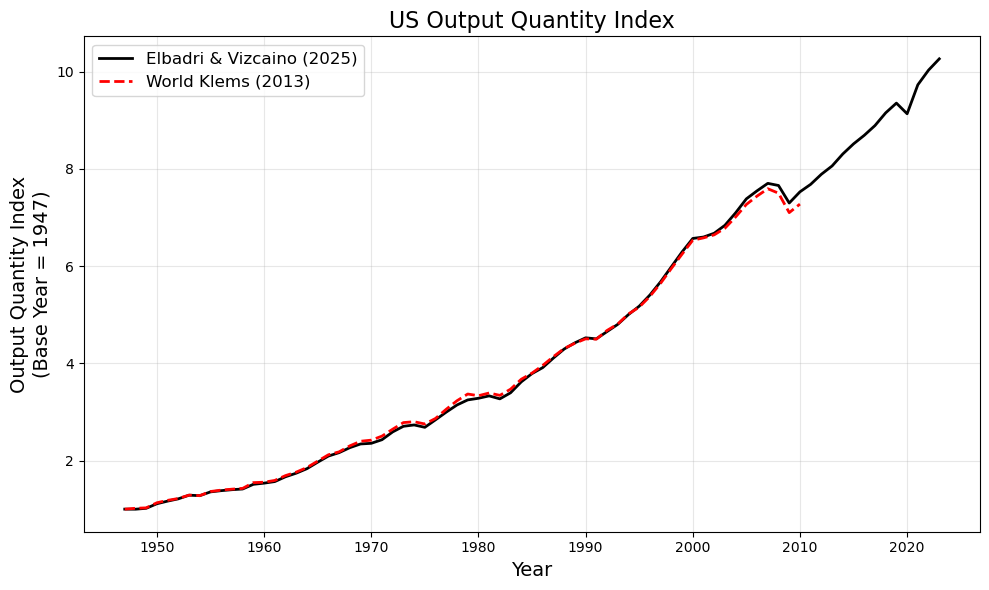

In [28]:
plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['GO_QI'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['GO_QI'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Output Quantity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Output Quantity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


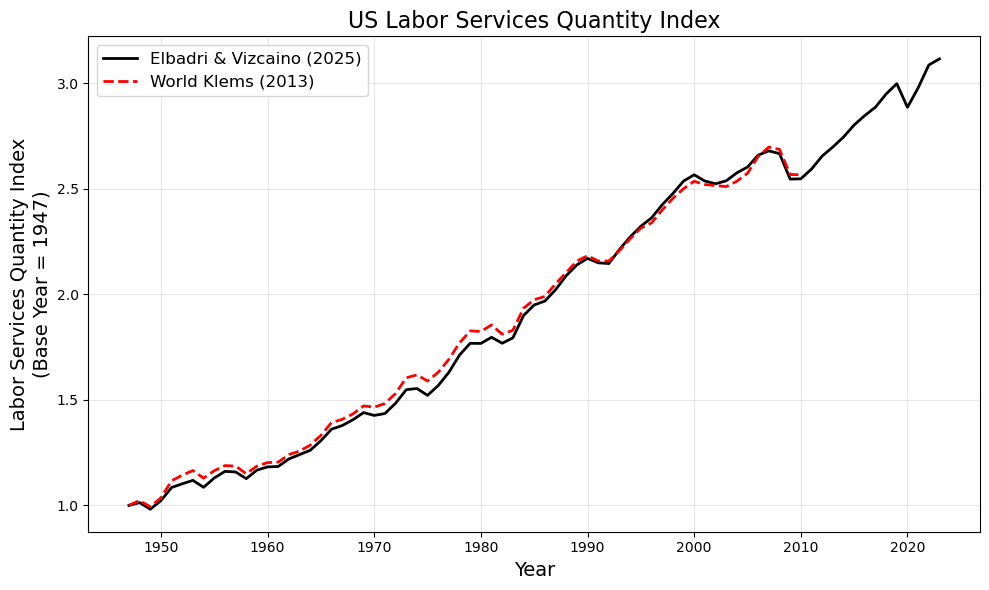

In [29]:
plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['LAB_QI'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['LAB_QI'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Labor Services Quantity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Labor Services Quantity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

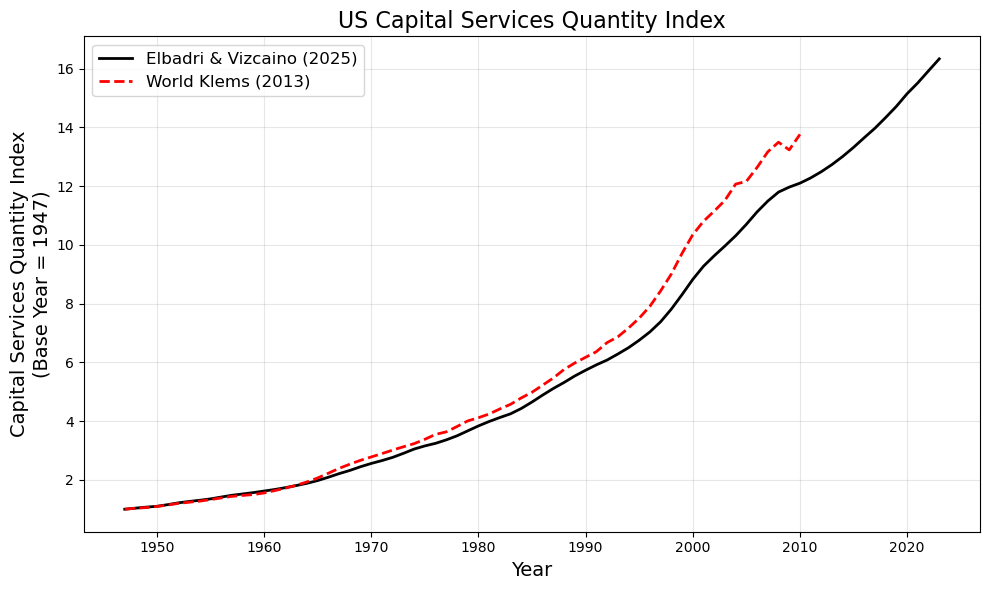

In [30]:

plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['CAP_QI'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['CAP_QI'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Capital Services Quantity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Capital Services Quantity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

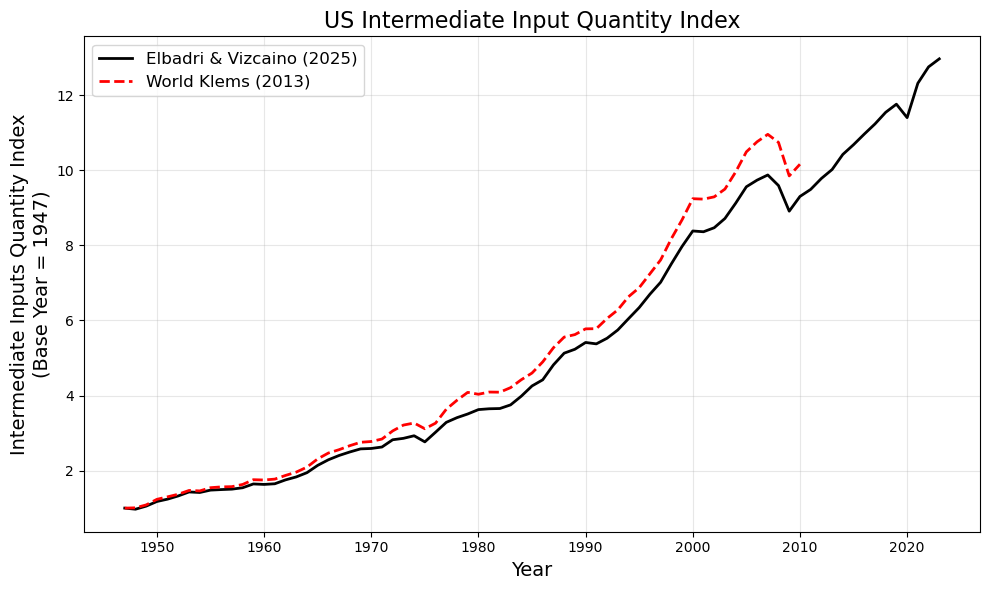

In [31]:

plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['II_QI'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['II_QI'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Intermediate Inputs Quantity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Intermediate Input Quantity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

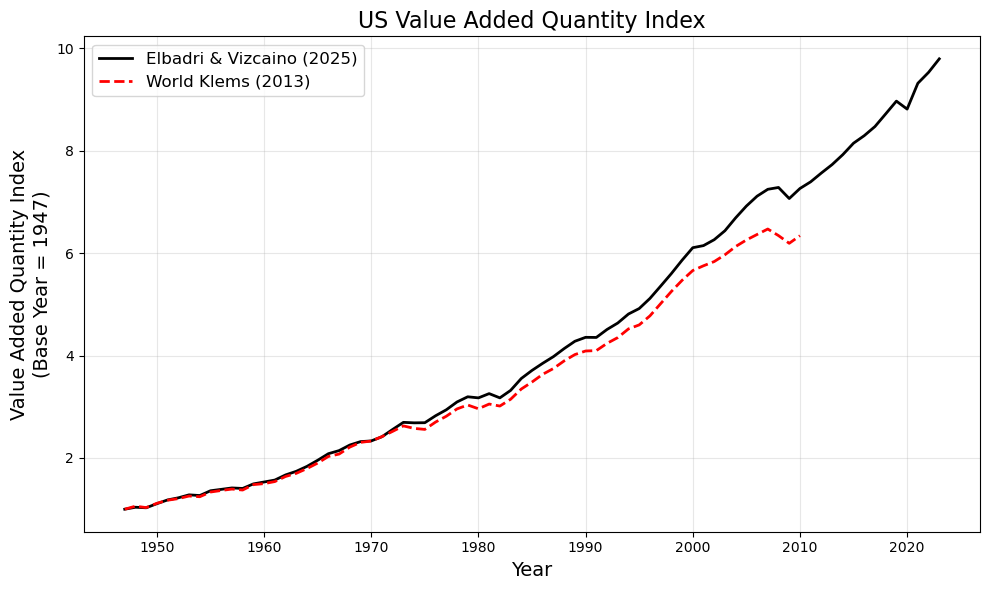

In [32]:

plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['VA_QI'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['VA_QI'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value Added Quantity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Value Added Quantity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

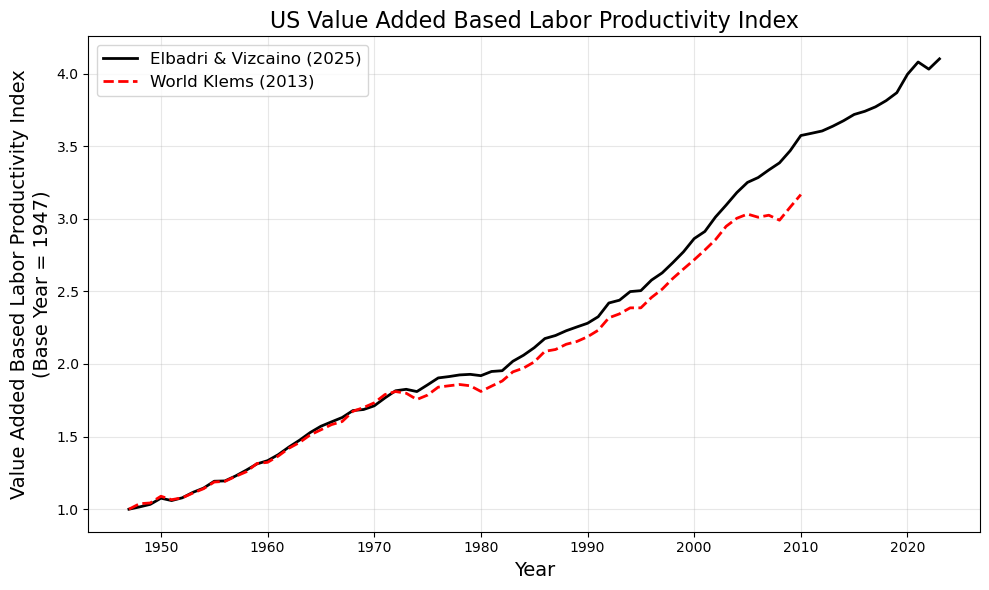

In [33]:

plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['LPVA'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['LPVA'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value Added Based Labor Productivity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Value Added Based Labor Productivity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

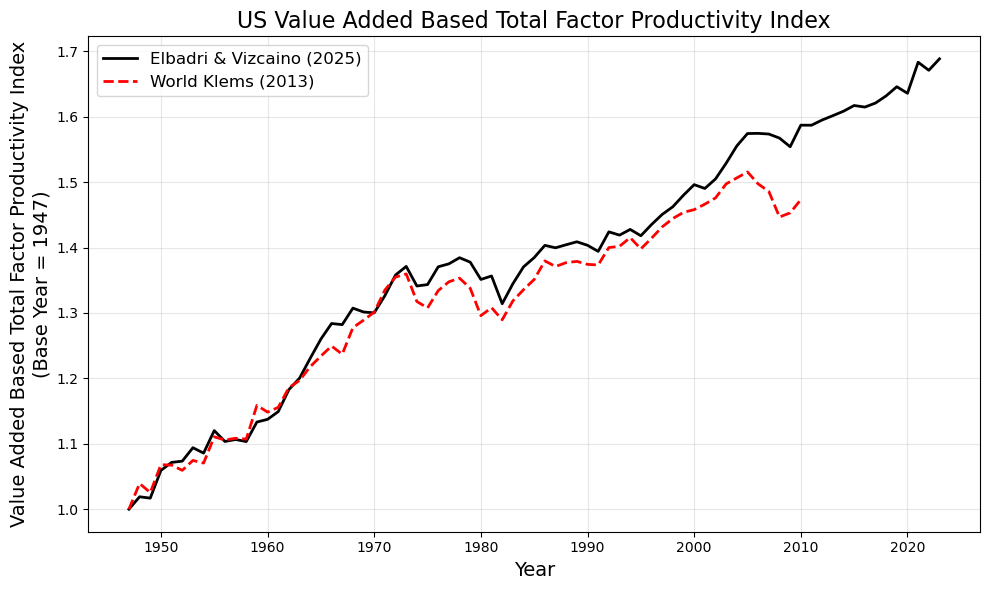

In [34]:

plt.figure(figsize=(10,6))
plt.plot(results['EV_full']['year'], results['EV_full']['TFPVA'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(results['wk_2013']['year'], results['wk_2013']['TFPVA'], color='red', linestyle='--', linewidth=2, label='World Klems (2013)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value Added Based Total Factor Productivity Index\n(Base Year = 1947)', fontsize=14)
plt.title("US Value Added Based Total Factor Productivity Index", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<a id="55-rebase-pwt-tfp-measure-to-1954"></a>
#### 5.5 Rebase PWT TFP measure to 1954

1954 is the first available year of TFP data in the Penn World Tables. We thus rebase both the Penn World Tables and our dataset to 1954 for comparsion.

In [35]:
pwt110_usa          = pwt110_data.loc[pwt110_data['countrycode'] == 'USA', ['countrycode', 'year', 'rtfpna']]
first_val           = pwt110_usa['rtfpna'].dropna().iloc[0]
pwt110_usa['TFPVA'] = pwt110_usa['rtfpna']/first_val

In [36]:
base_year                         = 1954
base_val                          = results['EV_full'].loc[results['EV_full']['year'] == base_year, 'TFPVA'].dropna().iloc[0]
results['EV_full']['TFPVA']       = results['EV_full']['TFPVA']/base_val

<a id="56-plot-results-and-compare-with-penn-world-tables-v11-0"></a>
#### 5.6 Plot results and compare with Penn World Tables, v11.0

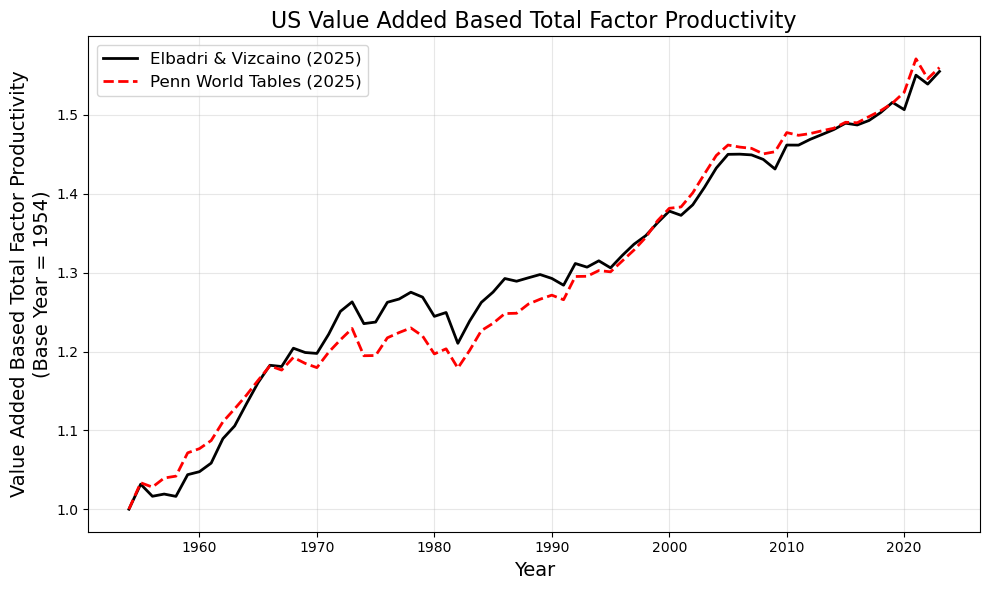

In [37]:
base_year = 1954
ev_tfp    = results['EV_full']['year'] >= base_year
pwt_tfp   = pwt110_usa['year'] >= base_year

plt.figure(figsize=(10,6))
plt.plot(results['EV_full'].loc[ev_tfp, 'year'], results['EV_full'].loc[ev_tfp, 'TFPVA'], color='black', linestyle='-', linewidth=2, label='Elbadri & Vizcaino (2025)')
plt.plot(pwt110_usa.loc[pwt_tfp, 'year'], pwt110_usa.loc[pwt_tfp, 'TFPVA'], color='red', linestyle='--', linewidth=2, label='Penn World Tables (2025)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value Added Based Total Factor Productivity\n(Base Year = 1954)', fontsize=14)
plt.title('US Value Added Based Total Factor Productivity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()